# Analysing a Noisy ECG Signal

In this tutorial we'll be looking at how to analysis a particularly noisy ECG signal using HeartPy. In ECG analysis the pre-processing steps are a bit different from PPG signals due to differing peak morphology, but general analysis is handled the same way.

We'll be using data from the [MIT-BIH Noise Stress Test Dataset](https://physionet.org/content/nstdb/1.0.0/).

These data have to be loaded with the [wfdb package](https://pypi.org/project/wfdb/), but for the purpose of this tutorial we have converted four of the files to .csv data for ease of use. All files are recorded at **360 Hz**

We'll be using these files with varying signal-to-noise (SNR) ratios:

- 118e24 : SNR: 24dB
- 118e12 : SNR = 12dB
- 118e06 : SNR = 6dB
- 118e00 : SNR = 0dB

These files have noisy and non-noisy sections. To keep download size low we have extracted a two-minute section of the noisy segment to work with, since noise is what this tutorial is about.

Let's get started and see where HeartPy cannot work with the signal anymore! 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heartpy as hp

sample_rate = 360

Let's load some data with the best SNR and visualise to see what we're working with!

**Since we'll be doing this a lot let's write a handy function right away.**

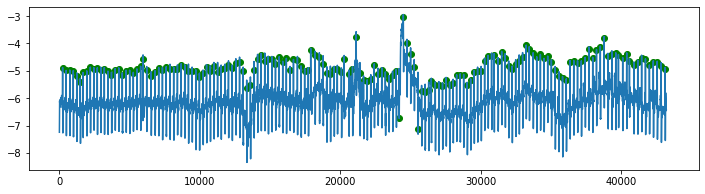

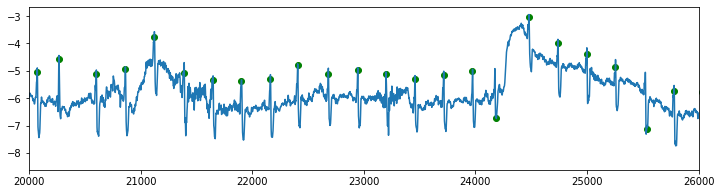

In [2]:
def load_visualise(data_file, annotations_file):
    '''
    loads data and annotations, plots them 
    and returns data and annotations
    '''
    
    
    #load the data
    ecg = hp.get_data(data_file)

    #get the annotations
    annotations = hp.get_data(annotations_file)
    #explore signal
    plt.figure(figsize=(12,3))
    plt.plot(ecg)
    plt.scatter(annotations, [ecg[int(x)] for x in annotations], color='green')
    plt.show()

    #and zoom in
    plt.figure(figsize=(12,3))
    plt.plot(ecg)
    plt.scatter(annotations, [ecg[int(x)] for x in annotations], color='green')
    plt.xlim(20000, 26000)
    plt.show()
    
    return ecg, annotations

ecg, annotations = load_visualise('118e24.csv', '118e24_ann.csv')

#### That looks pretty ok.

Note that the annotations supplied with the dataset have small errors. This is because of how these are usually annotated: peaks are automatically marked and manually corrected where necessary. Due to the immense amount of work (1 hour of ECG will contain on average 3600 peaks already!) small errors are generally deemed acceptable and remain. Only peaks at strange positions are corrected. Let's see if HeartPy can do better!

-----

There's one small and one larger noise peak but otherwise there's not a lot of noise going on. Analysing this should be relatively straightforward. The biggest problem here can be summarized as **baseline wander**

HeartPy comes with a function located in ***hp.remove_baseline_wander(data, sample_rate, cutoff=0.05)*** that can help with this. It applies a notch filter around a narrow frequency range (default : 0.05Hz). This removes baseline wander but does not introduce any phase shift, meaning our QRS-complexes and thus peaks remain at the same position, which is exactly what we want.

To demonstrate (and again let's write a function):

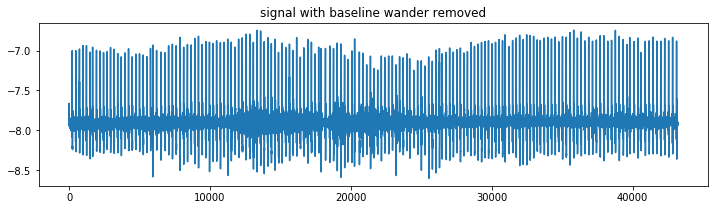

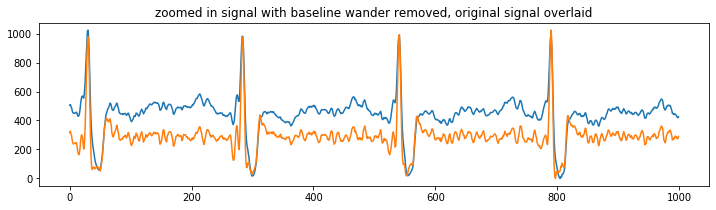

In [3]:
def filter_and_visualise(data, sample_rate):
    '''
    function that filters using remove_baseline_wander 
    and visualises result
    '''
    
    filtered = hp.remove_baseline_wander(data, sample_rate)

    plt.figure(figsize=(12,3))
    plt.title('signal with baseline wander removed')
    plt.plot(filtered)
    plt.show()

    #And let's plot both original and filtered signal, and zoom in to show peaks are not moved
    #We'll also scale both signals with hp.scale_data
    #This is so that they have the same amplitude so that the overlap is better visible
    plt.figure(figsize=(12,3))
    plt.title('zoomed in signal with baseline wander removed, original signal overlaid')
    plt.plot(hp.scale_data(data[200:1200]))
    plt.plot(hp.scale_data(filtered[200:1200]))
    plt.show()
    
    return filtered

filtered = filter_and_visualise(ecg, sample_rate)

#### As you can see the maxima of the peaks still overlap, which is what we're interested in.

If you ever filter and observe that peak positions start shifting, beware that you're introducing noise into your measurements. HRV measures are **especially** sensitive to outliers! 

If all peaks have a similar phase shift that is fine, but if they start changing shapes so that the maxima change position, this can be problematic.

-----------

Now let's run the analysis. We scale the data after filtering using ***hp.scale_data()***, which is a linear operation and so doesn't 

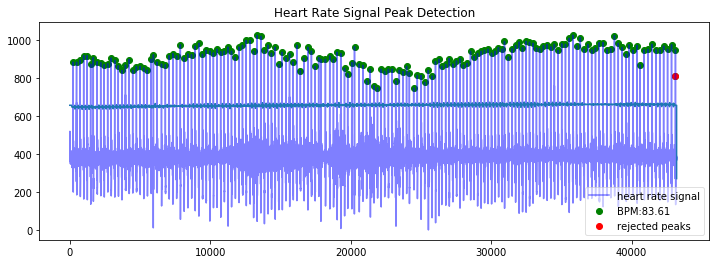

bpm: 83.607704
ibi: 717.637216
sdnn: 63.436841
sdsd: 84.003620
rmssd: 97.965175
pnn20: 0.381818
pnn50: 0.218182
hr_mad: 20.833333
breathingrate: 0.358333


In [4]:
wd, m = hp.process(hp.scale_data(filtered), sample_rate)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

### That looks good

But then again, the signal wasn't particularly challenging actually. 

----------

Let's move on to the next one with a SNR or 12dB. We can use the function we wrote earlier:

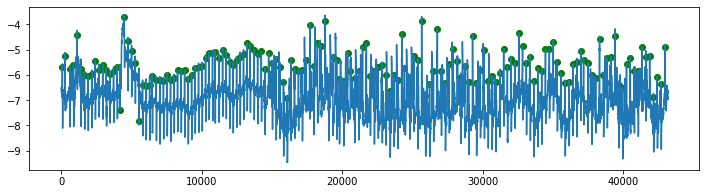

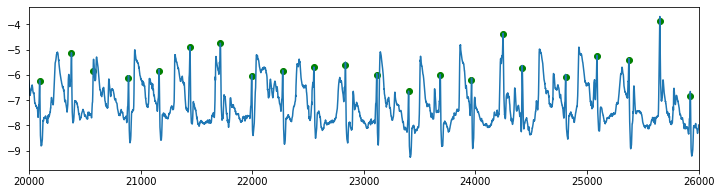

In [5]:
ecg, annotations = load_visualise('118e12.csv', '118e12_ann.csv')

#### It's getting a bit more challenging, but ecg waveforms are still quite visible in the signal

Aside from baseline wander, ***remove_baseline_wander*** will also (to a lesser extent) respond to the lower frequency noise in the signal. We can try if this cleans up the signal enough:

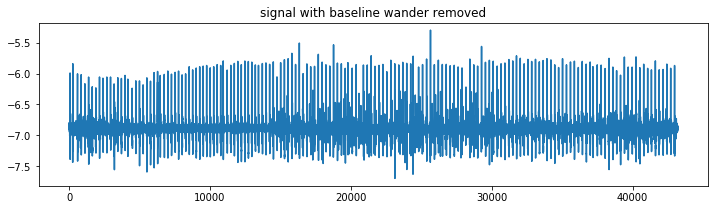

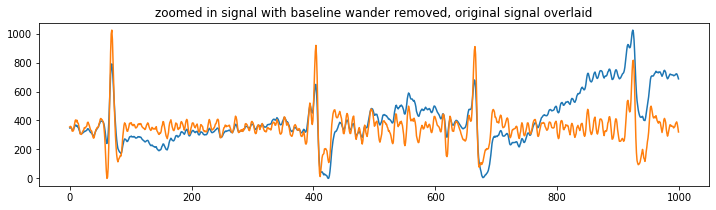

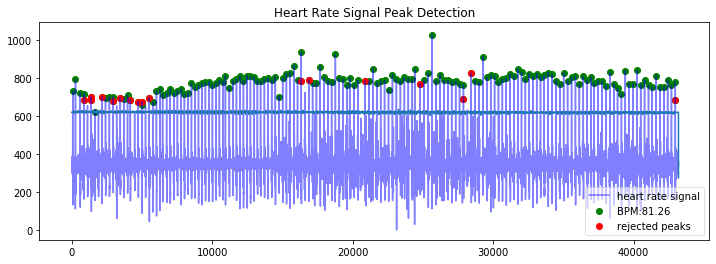

bpm: 81.264108
ibi: 738.333333
sdnn: 62.972766
sdsd: 74.492314
rmssd: 83.750777
pnn20: 0.259843
pnn50: 0.149606
hr_mad: 19.444444
breathingrate: 0.258333


In [6]:
filtered = filter_and_visualise(ecg, sample_rate)

wd, m = hp.process(hp.scale_data(filtered), sample_rate)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### It works ok, but there's some rejections where they shouldn't me (correct peaks marked as incorrect).

Why is this?

ECG generally has very narrow peaks. Filtering usually keeps the maximum at the same place but can narrow the waveform further, causing issues. 

Because HeartPy was designed for much wider PPG waveforms, upsampling generally does the trick and doesn't move change relative peak positions:

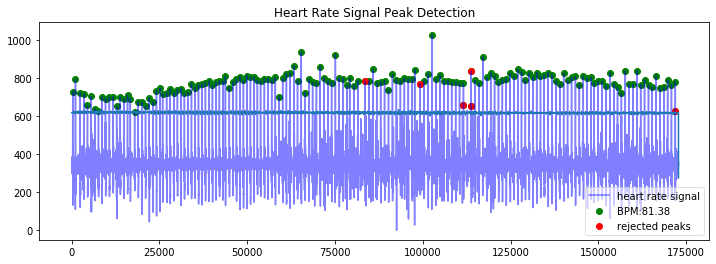

bpm: 81.378971
ibi: 737.291213
sdnn: 60.335413
sdsd: 72.855687
rmssd: 82.042853
pnn20: 0.302013
pnn50: 0.147651
hr_mad: 25.694444
breathingrate: 0.150000


In [7]:
from scipy.signal import resample

resampled_signal = resample(filtered, len(filtered) * 4)

wd, m = hp.process(hp.scale_data(resampled_signal), sample_rate * 4)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### That's improved the detection significantly.

If you're working with ECG and need to filter, we recommend you upsample with an even factor. A factor between 4-10 is usually sufficient.

---------

Now let's move on to a more challenging signal with an SNR of 6dB:

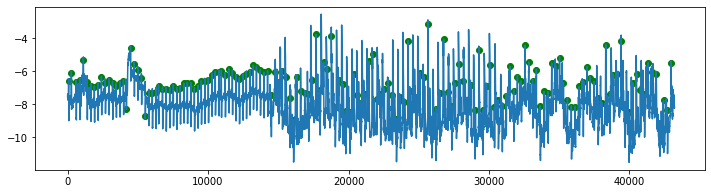

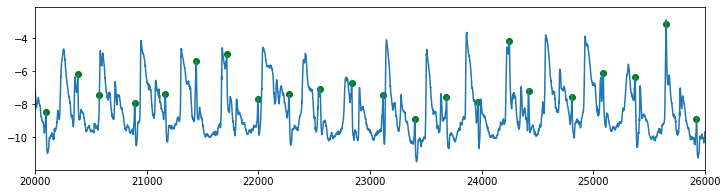

In [8]:
ecg, annotations = load_visualise('118e06.csv', '118e06_ann.csv')

#### Here we get into challenging territory

Most QRS-complexes are still visible if you know what to look for, although the amplitude of the noise is relatively quite large and at points noise spikes coincide with the QRS-complex, masking it.

Since HeartPy 1.2.5 there's a function called ***enhance_ecg_peaks(data, sample_rate)***.

The function generates a set of synthetic QRS complexes of different widths and shapes based on the sample_rate, and convolves the signal with each synthetic QRS complex. The convolution will react strongly to anything that looks like it, but not to other shapes (or sizes!). This has the effect of improving signal-to-noise ratio without influencing peak positions.

Let's give it a spin:

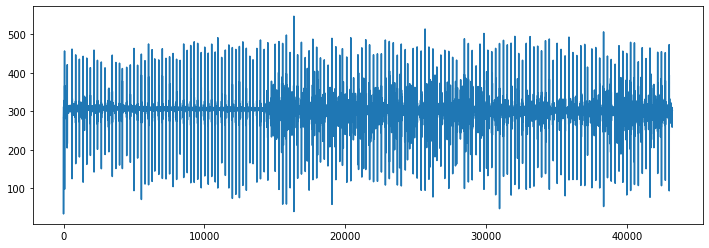

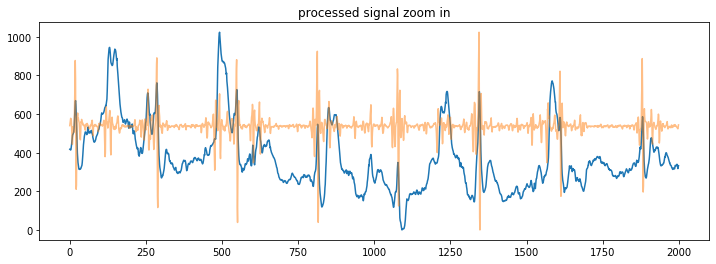

In [9]:
filtered = hp.enhance_ecg_peaks(hp.scale_data(ecg), sample_rate, 
                                aggregation='median', iterations=5)

#show filtered signal
plt.figure(figsize=(12,4))
plt.plot(filtered)
plt.show()

#zoom in on signal section and overlay filtered segment 
plt.figure(figsize=(12,4))
plt.title('original signal zoom in')
plt.plot(hp.scale_data(ecg[15000:17000]))
plt.title('processed signal zoom in')
plt.plot(hp.scale_data(filtered[15000:17000]), alpha=0.5)
plt.show()

#### That looks nice! 

The QRS-complexes have been enhanced a lot while remaining at the same location*.

\*actually the whole signal shifts to the right n-1 datapoints where n is the number of iterations. HeartPy corrects for this.

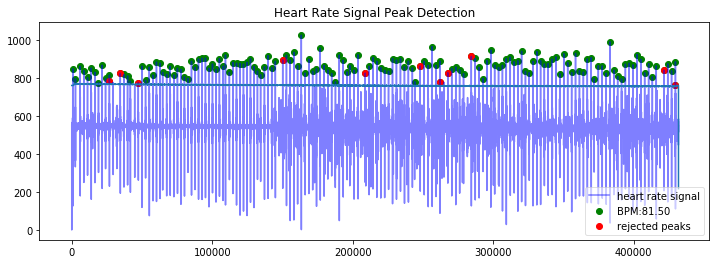

bpm: 81.500454
ibi: 736.192214
sdnn: 62.569284
sdsd: 74.268486
rmssd: 83.828045
pnn20: 0.296875
pnn50: 0.156250
hr_mad: 23.333333
breathingrate: nan


In [10]:
resampled_signal = resample(filtered, len(filtered) * 10)

wd, m = hp.process(hp.scale_data(resampled_signal), sample_rate * 10)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### That's pretty decent performance given the original (very noisy!) signal.

A few peaks have disappeared causing rejections of each subsequent peak, due to the creation of a too large peak-peak interval because of the missing peak in between. HeartPy rejects this subsequent peak and corresponding peak-peak interval so that the HRV measures are not distorted by it (they are very sensitive to outliers).

All in all, the performance is very good.

-------------

Now let's try an impossible signal with an SNR of 0dB

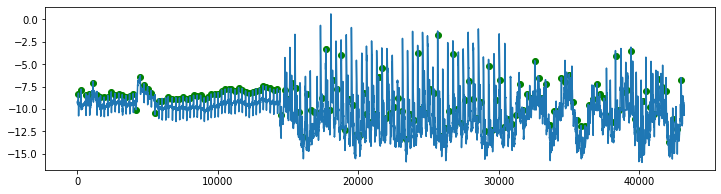

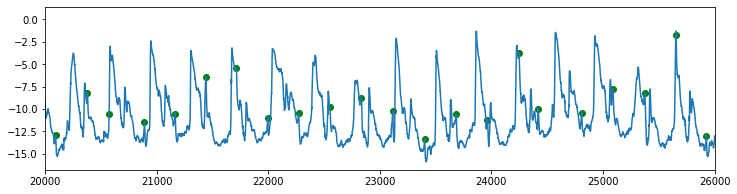

In [11]:
ecg, annotations = load_visualise('118e00.csv', '118e00_ann.csv')

As you can see the amplitude of many QRS complexes is really, really low compared to the noise.

Let's try the same convolutional filter and see if it can do somethhing about it.

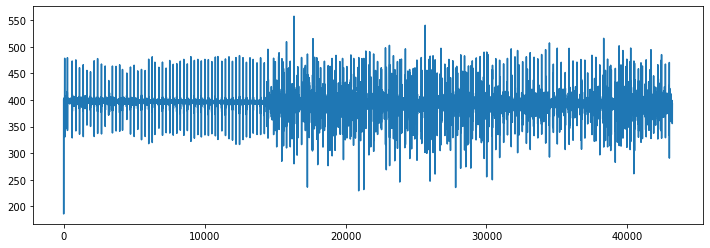

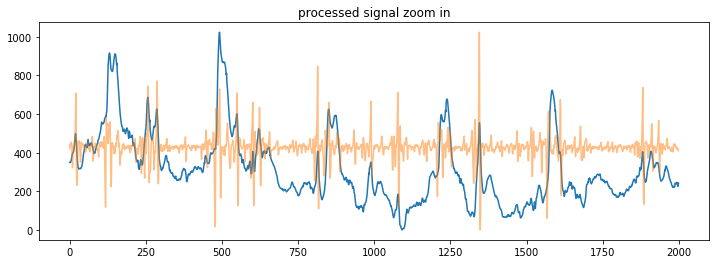

In [12]:
filtered = hp.enhance_ecg_peaks(hp.scale_data(ecg), sample_rate, 
                                aggregation='median', iterations=4)

plt.figure(figsize=(12,4))
plt.plot(filtered)
plt.show()

plt.figure(figsize=(12,4))
#plt.subplot(211)
plt.title('original signal zoom in')
plt.plot(hp.scale_data(ecg[15000:17000]))
#plt.subplot(212)
plt.title('processed signal zoom in')
plt.plot(hp.scale_data(filtered[15000:17000]), alpha=0.5)
plt.show()

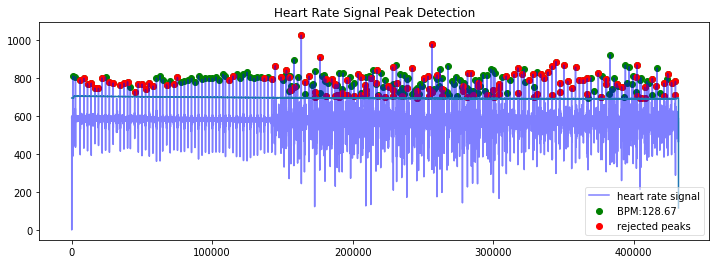

bpm: 128.673550
ibi: 466.296296
sdnn: 193.293256
sdsd: 162.020374
rmssd: 219.765641
pnn20: 0.603774
pnn50: 0.584906
hr_mad: 191.111111
breathingrate: nan


In [13]:
#filtered = hp.filter_signal(filtered, 0.05, sample_rate, filtertype='notch')

resampled_signal = resample(filtered, len(filtered) * 10)

wd, m = hp.process(hp.scale_data(resampled_signal), sample_rate * 10)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

#### Too bad, that is obviously not the right solution

(for now) we've come to the end of HeartPy's capabilities in the matter.

If you're ever stuck with a signal like this, the only thing you can reasonably do is remove the noisy part and analyse the rest where the signal is good, meaning [0:14500] for this example:

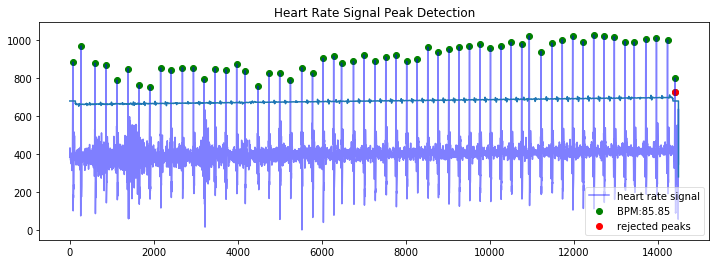

bpm: 85.851754
ibi: 698.879142
sdnn: 69.744691
sdsd: 90.204488
rmssd: 108.183148
pnn20: 0.428571
pnn50: 0.285714
hr_mad: 16.666667
breathingrate: 0.347586


In [14]:
filtered = hp.filter_signal(ecg[0:14500], 0.05, sample_rate, filtertype='notch')

wd, m = hp.process(hp.scale_data(filtered), sample_rate)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

## I hope this helped!

I hope this notebook has given you an insight into what you can do if you encounter particularly noisy ECG data!